In [ ]:
# correlation graphics 12 seeds ISNetDANN

In [1]:
# Objective:
# To check whether, when the model strongly encodes attributes such as sex, race, etc. (→ LR test AUROC),
# the fairness gap also increases.
# To confirm the presence of demographic shortcuts


In [ ]:
# NOTE: The difference is computed as C0 − C1 (C0, C1)
# The fairness gap is expressed as a percentage

In [1]:
from pathlib import Path
import json
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
def process_corr_results(attr_name: str, base_dir: Path, results_dir: Path, fairness_classes=(0, 1)):
    dirs = []
    overall_results = []
    test_results_attr = []
    lr_uncond_results = []

    c0, c1 = fairness_classes  # c0 will be subtracted from c1

    for i in base_dir.glob('**/done_eval'):
        dirs.append(str(i.parent))
        args = json.load((i.parent / 'args.json').open('r'))

        run_dir = base_dir / args['store_name'] / 'final_results_eval.pkl'
        with open(run_dir, "rb") as f:
            results = pickle.load(f)

        # Overall Test results
        results_te_overall = results['te']['overall']
        df_results_te_overall = pd.DataFrame.from_dict(results_te_overall, orient='index')

        # Overall Val results
        results_va_overall = results['va']['overall']
        df_results_va_overall = pd.DataFrame.from_dict(results_va_overall, orient='index')

        # Test results per attribute
        results_te_attr = results['te']['per_attribute']
        df_te_attr = pd.DataFrame(results_te_attr)

        # Fairness Gap
        if args['task'] == "No Finding":
            fair_gap = (df_te_attr.loc['FPR_opt'][c0] - df_te_attr.loc['FPR_opt'][c1]) * 100
            fair_metric = 'FPR_opt'
        else:
            fair_gap = (df_te_attr.loc['FNR_opt'][c0] - df_te_attr.loc['FNR_opt'][c1]) * 100
            fair_metric = 'FNR_opt'

        # Store overall results
        overall_results.append({
            'store_name': args['store_name'],
            'seed': args['seed'],
            'hparams_seed': args['hparams_seed'],
            'task': args['task'],
            'AUROC_te': df_results_te_overall.loc['AUROC'].values[0],
            'balanced_acc_opt_te': df_results_te_overall.loc['balanced_acc_opt'].values[0],
            'FNR_opt_te': df_results_te_overall.loc['FNR_opt'].values[0],
            'FPR_opt_te': df_results_te_overall.loc['FPR_opt'].values[0],
            'f1_macro_opt_te': results_te_overall['macro_avg__opt']['f1-score'], 
            'AUROC_va': df_results_va_overall.loc['AUROC'].values[0],
            'balanced_acc_opt_va': df_results_va_overall.loc['balanced_acc_opt'].values[0],
            'FNR_opt_va': df_results_va_overall.loc['FNR_opt'].values[0],
            'FPR_opt_va': df_results_va_overall.loc['FPR_opt'].values[0],
            'f1_macro_opt_va': results_va_overall['macro_avg__opt']['f1-score'] 
        })

        #Store results per attribute (demographic subgroups)
        test_results_attr.append({
            'store_name': args['store_name'],
            'seed': args['seed'],
            'hparams_seed': args['hparams_seed'],
            'task': args['task'],
            f'AUROC_attr{c0}': df_te_attr.loc['AUROC'][c0],
            f'AUROC_attr{c1}': df_te_attr.loc['AUROC'][c1],
            f'balanced_acc_attr{c0}': df_te_attr.loc['balanced_acc_opt'][c0],
            f'balanced_acc_attr{c1}': df_te_attr.loc['balanced_acc_opt'][c1],
            f'FNR_opt_attr{c0}': df_te_attr.loc['FNR_opt'][c0],
            f'FNR_opt_attr{c1}': df_te_attr.loc['FNR_opt'][c1],
            f'FPR_opt_attr{c0}': df_te_attr.loc['FPR_opt'][c0],
            f'FPR_opt_attr{c1}': df_te_attr.loc['FPR_opt'][c1],
            'fair_gap': fair_gap,
            'fair_metric': fair_metric,
            'fair_gap_desc': f'{fair_metric} class {c0} - class {c1}'
        })

        # Store unconditional logistic regression results
        df_results_lr_uncond = pd.DataFrame(results['lr_uncond'])
        lr_uncond_results.append({
            'store_name': args['store_name'],
            'seed': args['seed'],
            'hparams_seed': args['hparams_seed'],
            'task': args['task'],
            'balanced_acc_va': df_results_lr_uncond.loc['balanced_acc']['va'],
            'balanced_acc_te': df_results_lr_uncond.loc['balanced_acc']['te'],
            'AUROC_va': df_results_lr_uncond.loc['AUROC']['va'],
            'AUROC_te': df_results_lr_uncond.loc['AUROC']['te'],
            f'class_{c0}_AUROC_va': df_results_lr_uncond.loc[f'class_{c0}_AUROC']['va'],
            f'class_{c0}_AUROC_te': df_results_lr_uncond.loc[f'class_{c0}_AUROC']['te'],
            f'class_{c1}_AUROC_va': df_results_lr_uncond.loc[f'class_{c1}_AUROC']['va'],
            f'class_{c1}_AUROC_te': df_results_lr_uncond.loc[f'class_{c1}_AUROC']['te']
        })

    print(f'Total runs for {attr_name}:', len(dirs))

    # Create and save DataFrames
    df_overall = pd.DataFrame(overall_results)
    df_attr = pd.DataFrame(test_results_attr)
    df_lr = pd.DataFrame(lr_uncond_results)

    results_dir.mkdir(parents=True, exist_ok=True)
    df_overall.to_csv(results_dir / f'overall_results_all_{attr_name}.csv', index=False)
    df_attr.to_csv(results_dir / f'test_results_attr_{attr_name}.csv', index=False)
    df_lr.to_csv(results_dir / f'lr_results_all_{attr_name}.csv', index=False)

    print(f"CSV guardados en: {results_dir}")
    return df_overall, df_attr, df_lr


In [3]:
def merge_dfs(df_overall, df_attr, df_lr, attr_name):
    # Rename columns
    df_lr = df_lr.rename(columns={'AUROC_te': 'attr_lr_auroc_te'})
    df_overall = df_overall.rename(columns={'AUROC_va': 'overall_val_auroc'})

    # Merge using store_name and task
    df = df_attr.merge(df_lr, on=['store_name', 'seed', 'hparams_seed' ,'task'])
    df = df.merge(df_overall[['store_name', 'task', 'overall_val_auroc']], on=['store_name', 'task'])

    df['attribute'] = attr_name
    return df


In [4]:
def pearson_ci(r, n, alpha=0.05):
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    z_crit = 1.96  # 95% CI
    
    z_lower = z - z_crit * se
    z_upper = z + z_crit * se
    
    r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
    r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)
    
    return r_lower, r_upper

def slope_ci(X,y):  
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()

    slope = model.params['fair_gap']
    intercept = model.params['const']
    pval_slope = model.pvalues['fair_gap']
    pval_intercept = model.pvalues['const']
    r_squared = model.rsquared
    slope_95ci = model.conf_int().loc['fair_gap']

    return slope, intercept, pval_slope, pval_intercept, r_squared, slope_95ci

In [5]:
def plot_fairness_vs_attr_auroc(df_all_attrs):

    results_plots=[]
    
    sns.set(style='whitegrid')
    
    # Get unique combinations of task and attribute
    combinations = df_all_attrs[['task', 'attribute']].drop_duplicates()
    n_plots = len(combinations)

    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 4), squeeze=False)
    axes = axes[0] # flatten if there is only one row

    for ax, (_, row) in zip(axes, combinations.iterrows()):
        task = row['task']
        attr = row['attribute']
        
        # Filter by task and attribute
        sub_df = df_all_attrs[(df_all_attrs['task'] == task) & (df_all_attrs['attribute'] == attr)]

        # Exclude suboptimal models
        sub_df = sub_df[sub_df['overall_val_auroc'] >= 0.7]

        x = sub_df['fair_gap']
        y = sub_df['attr_lr_auroc_te']
        
        if len(sub_df) >= 2:
            r, p = pearsonr(x, y)

            n = len(x)
            r_95ci_lower, r_95ci_upper=pearson_ci(r,n) 

            slope, intercept, pval_slope, pval_intercept, r_squared, slope_95ci = slope_ci(x, y)

        else:
            r, p = float('nan'), float('nan')
            r_95ci_lower, r_95ci_upper = float('nan'), float('nan')
            slope, intercept = float('nan'), float('nan')
            pval_slope, pval_intercept = float('nan'), float('nan')
            r_squared, slope_95ci = float('nan'), float('nan')
        

        results_plots.append({
            'task': task,
            'attr': attr,
            'r':r,
            'p':p,
            'r_95ci_lower':r_95ci_lower,
            'r_95ci_upper':r_95ci_upper,
            'r_95ci_dif': r_95ci_upper - r_95ci_lower,
            'slope': slope,
            'intercept': intercept,
            'pval_slope': pval_slope,
            'slope_95ci_lower': slope_95ci[0],
            'slope_95ci_upper': slope_95ci[1],
            'slope_95ci_dif': slope_95ci[1]-slope_95ci[0],
            'r_squared': r_squared
        })

        print("results")
        print(task)
        print(attr)
        print("valores con overall_val_auroc > 0.7: ", len(sub_df))
        print("r = ", r)
        print("p = ", p)
        
        
        # regplot: plot data and fit a linear regression model
        # (95% confidence interval for the regression line)
        sns.regplot(data=sub_df, x='fair_gap', y='attr_lr_auroc_te',
                    ax=ax, scatter_kws={'s': 40}, line_kws={'color': 'black'})

        ax.set_title(f"ISNetDANN: {task}, {attr.capitalize()}\nR = {r:.2f}, P = {p:.1e}", fontsize=12)
        ax.set_xlabel("Fairness gap (%)")
        ax.set_ylabel("Attribute prediction AUROC")

    plt.tight_layout()
    plt.show()

    df_results_plots = pd.DataFrame(results_plots)

    # Sort results
    task_order = ['No Finding', 'Pleural Effusion', 'Cardiomegaly', 'Pneumothorax']
    df_results_plots['task'] = pd.Categorical(df_results_plots['task'], categories=task_order, ordered=True)
    df_results_plots = df_results_plots.sort_values('task')
    
    return df_results_plots

In [ ]:
#==========================SEX=====================================

In [6]:
# Load sex results: for sex: female (0) – male (1): 0 − 1

df_overall_sex, df_attr_sex, df_lr_sex=process_corr_results(
    attr_name='sex',
    base_dir=Path('/home/lchanch/model_training/ISNetDANN/train/grid_sex_ISNetDANN'),
    results_dir=Path('/home/lchanch/model_training/ISNetDANN/eval/eval_sex/eval_6_seed_hp8/results_corr_graphics/'),
    fairness_classes=(0, 1)
)

Total runs for sex: 32
CSV guardados en: /home/lchanch/model_training/ISNetDANN/eval/eval_sex/eval_6_seed_hp8/results_corr_graphics


In [9]:
df_lr_sex.to_csv('archivo_df_lr_sex.csv', index=False) #-all

In [10]:
df_sex=merge_dfs(df_overall_sex, df_attr_sex, df_lr_sex, 'sex')
df_sex.head(1)

,store_name,seed,hparams_seed,task,AUROC_attr0,AUROC_attr1,balanced_acc_attr0,balanced_acc_attr1,FNR_opt_attr0,FNR_opt_attr1,...,balanced_acc_va,balanced_acc_te,AUROC_va,attr_lr_auroc_te,class_0_AUROC_va,class_0_AUROC_te,class_1_AUROC_va,class_1_AUROC_te,overall_val_auroc,attribute
0,b27dd33301c5fb5687a02dd030985e82,1,0,No Finding,0.815174,0.78582,0.732961,0.718118,0.374829,0.392757,...,0.624551,0.629902,0.703146,0.709153,0.703146,0.709153,0.703146,0.709153,0.7987,sex


In [11]:
df_sex_final=df_sex[df_sex['overall_val_auroc'] >= 0.7]

In [12]:
df_sex_corr=df_sex_final[['task','fair_gap','attr_lr_auroc_te']]
df_sex_corr

,task,fair_gap,attr_lr_auroc_te
0,No Finding,-1.175731,0.709153
1,No Finding,0.172781,0.762220
2,No Finding,1.023295,0.758447
3,No Finding,3.069147,0.762221
4,No Finding,-3.119702,0.768826
5,No Finding,-0.918143,0.758012
6,No Finding,-1.799975,0.761494
7,No Finding,-1.563938,0.769834
8,No Finding,-2.232189,0.749151
9,No Finding,0.354111,0.770229


results
No Finding
sex
valores con overall_val_auroc > 0.7:  32
r =  -0.07923132924883507
p =  0.6664343458067071


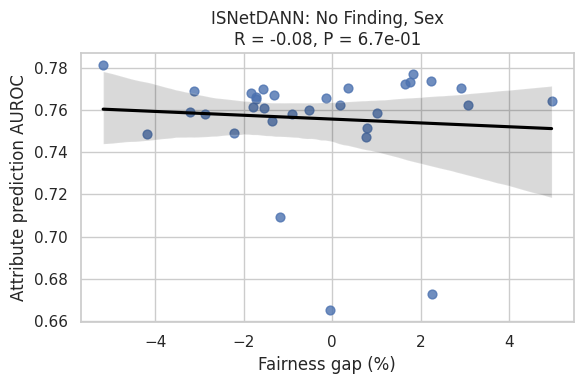

,task,attr,r,p,r_95ci_lower,r_95ci_upper,r_95ci_dif,slope,intercept,pval_slope,slope_95ci_lower,slope_95ci_upper,slope_95ci_dif,r_squared
0,No Finding,sex,-0.079231,0.666434,-0.416426,0.277125,0.693551,-0.000905,0.755625,0.666434,-0.005149,0.00334,0.008489,0.006278


In [13]:
plot_fairness_vs_attr_auroc(df_sex)

In [ ]:
#==========================SEX=====================================